<a href="https://colab.research.google.com/github/patrickabadi/python-pytorch-notebooks/blob/main/Module3_CNN_to_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IVADO-Mila Deep Learning School
# Spring 2021
# Tutorial : Image classification and object detection with CNNs

## Authors: 


Jeremy Pinto 

Margaux Luck 

Pierre Luc Carrier 

Mathieu Germain 

### Translation to English: 

Laurent Charlin 

## Intro

The first part of this tutorial uses concrete examples to introduce the fundamental concepts behind convolutional neural networks.

The second part of this tutorial is entirely optional but it covers more advanced tasks (object detection and instance segmentation) and it does so in a transfer learning setting. You are encouraged to attempt it if you wish to deepen your understanding of the material.

# Task 1 : Image classification

## Initialization

Before we begin, you must ensure to install all required libraries for this part of the tutorial. To do so, we will use the `pip` utility. Simply execute the cell below by selecting it and pressing `shift`+`Enter`. (This operation may take a few minutes.)

We need to be using the latest version of `pillow` for this tutorial. If you are prompted with:

> WARNING: The following packages were previously imported in this runtime:
  [PIL]
You must restart the runtime in order to use newly installed versions.

Then click on restart runtime and rerun the cells afterwards.

In [1]:
!pip3 install torch torchvision matplotlib
!pip3 install --upgrade pillow==8.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 MB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pillow: filename=Pillow-8.1.0-cp310-cp310-linux_x86_64.whl size=1330182 sha256=8456ca175b23cc7939e4c0d209109ebc4a8ed74b38128662a49ee708da1f94f0
  Stored in directory: /root/.cache/pip/wheels/69/ff/e2/ff104a7329d86003512672dcce62234921a9bfb347340fd52c
Successfully built pillow
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.25.1 requires pillow>=8.3.2, but you have pill

In [2]:
import torch

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  2.0.1+cu118
GPU Available: True


## The MNIST dataset
MNIST is the classic go-to **classification dataset** used in **computer vision**. It is available here: <a href="http://yann.lecun.com/exdb/mnist/">Yann LeCun's website</a>. 

Each datum is an **image of a handwritten digit**. Here are a few examples from this dataset: 

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/mnist.png?raw=true)

Each image also comes with a **class label** which indicates which digit does the image correspond to. For example, the labels of the examples above are 5, 0, 4, and 1 respectively. The classes are balanced which means that all digits appear (roughly) the same number of times in the dataset.

The dataset is composed of **60 000 training examples** and **10 000 test examples**. All images have exactly the same size (**28x28 pixels** or 28 rows by 28 columns). Each pixel is represented by a number between 0 and 255 which represents its grey level (0 is white and 255 is black). Depending on the model, each image may have to be flattened (to a 784-length vector).

### Objective

Our goal is to find a model that correctly classifies these images. In particular, our model will take as input (features/covariates/independant-variables) an image and will predict its digit (label/dependant variable). This problem can be formalized as follows:

`f(image) = predicted digit`

where `f` is a function.

In this tutorial, we will consider both **multi-layer perceptrons (MLPs)** and **convolutional neural networks** as functions for solving this prediction problem. Both models take as inputs pixel intensities which will be modified using mathematical operations through the layers of the networks. Their output is a vector of size *1x10* where each entry corresponds to the (normalized) score that the input image is a particular digit. The sum over these 10 values is 1, and each score is non-negative. This is why these scores can be interpreted as probabilities. Our final prediction will be the entry with the highest score. For example, this prediction

`[0.8, 0.1, 0, 0, 0, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0]`

indicates that the model assigns a score of 0.8 to class 0.

Learning implies finding the parameters of a model that will maximize the model's performance. To learn, we will start by randomly initializing the parameters of our model. Then we iterate through examples. For each example we will obtain the network's prediction, compare it with the true label, and then update the parameters of the models to obtain a better prediction. We do this until we reach some predetermined stopping criteria.

### Download the dataset and create the data loader

Before we begin training, we have to obtain the MNIST dataset. It turns out that there are built-in functions within PyTorch to load this data, shuffle it and augment it.

Here is an easy way to load some data in PyTorch: 
1. Subclass <a href="http://pytorch.org/docs/master/data.html#torch.utils.data.Dataset">`torch.utils.data.Dataset`</a> and add  `__getitem__` and `__len__` methods.
2. Then you can use<a href="http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader">`torch.utils.data.DataLoader`</a> to read and load the data into memory.

It is even easier for MNIST in PyTorch since there is already a subclass of "datasets" defined for it: <a href="http://pytorch.org/docs/master/torchvision/datasets.html#mnist">`torchvision.datasets.MNIST`</a>.

<a href="http://pytorch.org/docs/master/torchvision/datasets.html">Other datasets are also similarly available</a>

**Note:** <a href="http://pytorch.org/docs/master/tensors.html#torch.Tensor.view">`torch.Tensor.view()`</a> returns a new tensor with the same data as the original tensor but a different shape. For example, it can be used to flatten an image.

In [3]:
import numpy as np
import random
import torch
from torch.utils.data import sampler, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms


manualSeed = 1234
use_gpu = torch.cuda.is_available()

# Fixing random seed
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
if use_gpu:
   torch.cuda.manual_seed_all(manualSeed)

class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    From: https://github.com/pytorch/vision/issues/168
    
    Parameters
    ----------
    num_samples: int
      # of desired datapoints
    start: int
      Offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples


train_dataset = MNIST(root='../data', 
                      train=True, 
                      transform=transforms.ToTensor(),  
                      download=True)

test_dataset = MNIST(root='../data', 
                     train=False, 
                     transform=transforms.ToTensor())

train_dataset_sizes = len(train_dataset)
num_train_samples = int(0.8 * train_dataset_sizes)
num_valid_samples = train_dataset_sizes - num_train_samples
num_test_samples = len(test_dataset)

print('# of train examples: {}'.format(num_train_samples))
print('# of valid examples: {}'.format(num_valid_samples))
print('# of test examples: {}'.format(num_test_samples))

batch_size = 128

train_loader = DataLoader(dataset=train_dataset,
                          sampler=ChunkSampler(num_train_samples, 0),
                          batch_size=batch_size, 
                          shuffle=False)

valid_loader = DataLoader(dataset=train_dataset,
                          sampler=ChunkSampler(
                              num_valid_samples, num_train_samples),
                          batch_size=batch_size, 
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 180602205.17it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 23631621.89it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 81919517.15it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8130827.47it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

# of train examples: 48000
# of valid examples: 12000
# of test examples: 10000


Let's visualize the training data!

Inputs size: torch.Size([128, 1, 28, 28])
Classes size: torch.Size([128])


Display a random image:


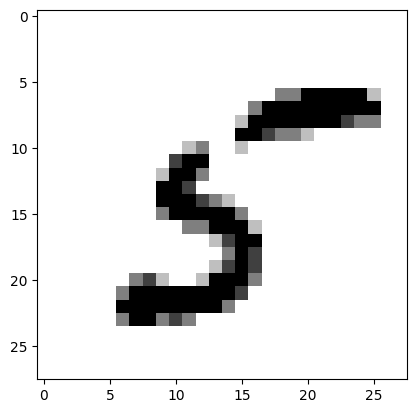

Label associated: 5


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

inputs, labels = next(iter(train_loader))

print('Inputs size: {}'.format(inputs.size()))
print('Classes size: {}'.format(labels.size()))

# Pick a random image of the batch
idx = np.random.randint(len(inputs))
img = 255 - inputs[idx] * 255

# Plot the image
print('\n\nDisplay a random image:')
img_np = img.numpy()[0, :, :] # Discard the channel dimension
plt.imshow(img_np, cmap='gray', vmin=0, vmax=255)
plt.grid(False)
plt.show()

# display the associated label
print(f"Label associated: {labels[idx]}")

## CPU or GPU
**Note:** <a href="http://pytorch.org/docs/master/cuda.html#module-torch.cuda">`torch.cuda`</a> is a library which can perform tensor operations using GPUs. Specifically, the library includes CUDA tensors which offer the same operations as regular tensors but instead run on GPUs, instead of CPUs.
<a href="http://pytorch.org/docs/master/cuda.html#torch.cuda.is_available">`torch.cuda.is_available()`</a> returns whether or not CUDA is available. Adding `.to("cuda:0")` to the variable identifying a CPU tensor, returns the equivalent GPU tensor.

For more information about using GPUs on colab, please refer to this [tutorial](https://colab.research.google.com/drive/1P7okDVh6viCIOkii6UAF2O9sTAcKGNWq).


In [5]:
use_gpu = torch.cuda.is_available()
print("GPU Available: {}".format(use_gpu))

GPU Available: True


We are going to compare the performance of a CNN to the performance of a vanilla MLP. Below is a quick reminder of MLPs, the architecture of the MLP we will be using, as well as the code to train the MLP. 

## Multi-layer perceptron (MLP)
A multi-layer perceptron is a vanilla feed-forward neural network. Our instanciation will take as input an image, will transform it through a series of hidden layers and then will pass it to an output layer. This output is a vector of 10 numbers where each represents the normalized score of a particular class (this is sometimes interpreted as a probability).

For example, here an MLP architecture to classify MNIST images: 
![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/mlp.png?raw=true)

Whenever you are trying to solve a prediction task, the process usually goes as follows: 
<ol>
<li>Determine the network's artchitecture. This will implicitely determine the number of parameters (weights and biases) of the network.</li>
<li>Determine the cost function and the optimization method.</li>
<li>Train the weights of the network (i.e., fit the model to train data).</li>
<li>Test the network (i.e., evaluate its performance on test data).</li>
</ol>

This procedure is general and applies to all types of (deep) neural networks.

### Toolbox

Racall that a (deep) neural network can be coded by using the library <a href="http://pytorch.org/docs/master/nn.html">`torch.nn`</a>. `nn` uses <a href="http://pytorch.org/docs/master/autograd.html">`torch.autograd`</a> to instantiate and compute the gradients (of the loss function with respect to the parameters).

In [6]:
import torch.nn as nn
import copy

input_size = 784
hidden_size = 500
num_classes = 10
learning_rate = 1e-2

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()

        self.hidden_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
            )
        
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, num_classes)
            )
    
    def forward(self, x):        
        out = self.hidden_layer(x)
        out = self.output_layer(out)
        return out

# Define our model
model = MLP(input_size, hidden_size, num_classes)
model = model.to(device) # switch model to GPU

print(model)
print("\n\n Number of parameters in the model (weights and biases): ", sum([param.nelement() for param in model.parameters()]))

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

MLP(
  (hidden_layer): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
  )
  (output_layer): Sequential(
    (0): Linear(in_features=500, out_features=10, bias=True)
  )
)


 Number of parameters in the model (weights and biases):  648010


In [7]:
import time

since = time.time()

num_epochs = 10
train_loss_history = []
valid_loss_history = []

print("# Start training #")
for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    model.train()
    
    # Iterate over train data
    for images, labels in train_loader:  
        
        # put images on proper device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Flatten the images
        images = images.view(-1, 28*28)

        # Zero the gradient buffer
        optimizer.zero_grad()  
        
        # Forward
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Backward
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model.eval()
    
    # Iterate over valid data
    for images, labels in valid_loader:  
        
        # put images on proper device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Flatten the images
        images = images.view(-1, 28*28)
        
        
        # Forward
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Statistics
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print('\nEpoch: {}/{}'.format(epoch + 1, num_epochs))
    print('\tTrain Loss: {:.4f}'.format(train_loss / train_n_iter))
    print('\tValid Loss: {:.4f}'.format(valid_loss / valid_n_iter))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Start training #

Epoch: 1/10
	Train Loss: 2.1725
	Valid Loss: 1.9143

Epoch: 2/10
	Train Loss: 1.3589
	Valid Loss: 0.8584

Epoch: 3/10
	Train Loss: 0.6958
	Valid Loss: 0.5438

Epoch: 4/10
	Train Loss: 0.5135
	Valid Loss: 0.4407

Epoch: 5/10
	Train Loss: 0.4387
	Valid Loss: 0.3903

Epoch: 6/10
	Train Loss: 0.3973
	Valid Loss: 0.3600

Epoch: 7/10
	Train Loss: 0.3705
	Valid Loss: 0.3392

Epoch: 8/10
	Train Loss: 0.3510
	Valid Loss: 0.3234

Epoch: 9/10
	Train Loss: 0.3355
	Valid Loss: 0.3104

Epoch: 10/10
	Train Loss: 0.3224
	Valid Loss: 0.2994


Training complete in 1m 29s


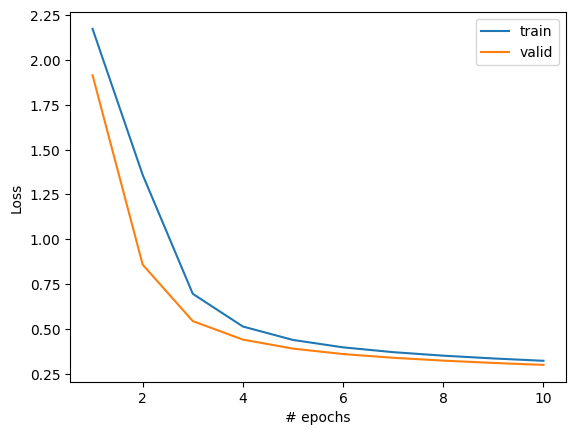

In [8]:
# Save history for later
mlp_train_loss_history = train_loss_history
mlp_valid_loss_history = valid_loss_history

# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, mlp_train_loss_history, label='train')
plt.plot(x, mlp_valid_loss_history, label='valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [9]:
# Set model to evaluate mode
model.eval()

correct = 0
total = 0

# Iterate over test data
for images, labels in test_loader:
    
    # put images on proper device (GPU)
    images = images.to(device)
    labels = labels.to(device)
    
    # Flatten the images
    images = images.view(-1, 28*28)

    # Forward
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # Statistics
    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)

print('Accuracy on the test set: {:.2f}%'.format(100 * correct / total))

Accuracy on the test set: 91.32%


## Convolutional neural networks (CNNs)




### Concepts

We first review the basic concepts that underlie CNNs.

**Convolution**

A convolution "slides" a filter *K* along image *I* to obtain an output *I*\**K*.

Here is an example of a 2D convolution:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/numerical_no_padding_no_strides.gif?raw=true)


**Filters**

Filters (or kernels) are used to extract information useful to the task from their input. Filters are generally of size *n* \* *n* where *n* is usually odd. The filters are parametrized by weights, one for each of its entry, which are learned by the convolutional network.

The filter used in the previous example is:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/d7acc4aeb74d9e9cb5fb51482a302196594837fe.png?raw=true)

**Depth**

We typically use *M* of filters which can be understood as the depth of the layer (see below). Note that this is different from the depth of the network (which is the number of layers). M is a hyperparameter. Here, each filter's output (blue circles) is represented as a single depth dimension on the output.

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/Conv_layer.png?raw=true)

**Stride**

The stride corresponds to the number of pixels the filter moves over in between each step of the convolution. The stride is measured in terms of a number of pixels. We typically use strides of 1 or 2. The larger the stride, the smaller the dimension of the output.

**Zero padding**

Zero padding consists in padding (adding) a border of zeros around the input image. This can be useful to preserve the dimension from input to output.

Below is an example of a zero padding which preserves the dimensions from input to output. Here, zero padding is set to 1, stride is set to 1, and the filter has size 3x3.

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/same_padding_no_strides.gif?raw=true)


**Max Pooling**

In addition to convolutions, CNNs usually have pooling layers. The goal of pooling is to reduce the dimensionality of the input in-between two convolution layers to reduce the number of parameters in the network. For example, the famous LeNet CNN, uses max pooling with 2x2 filters and a stride of 2. Max pooling outputs the max value in a 2x2 region. This output is then the input of the next layer.

Here is an example of the max pooling operation:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/maxpool.jpeg?raw=true)


**Receptive Field**

The receptive field is a measure of the CNNs' capacity to perceive information at different input scales. In an MLP (fully connected), the features are connected to every neuron. The receptive field of this MLP is the full image.

For CNNs, convolution operations typically imply sparse connections. In other words, each filter only has a local receptive field. However, each successive layer will have access to a slightly larger receptive field. 

Let's look at an example. Imagine a 3x3 filter with stride set to 1. In this case, the first layer's receptive field is a maximum of 3x3. However, the more layer we add the more we increase the network's receptive field. Adding a second layer with 3x3 filters and a stride of 1, our receptive field is increased to 5x5. Adding a third 3x3 layer further increases our receptive field to 7x7.

What is the advantage of using multiple smaller successive filters instead of a single larger one? A single large filter of 7x7 implies 49 parameters. Instead 3 layers of 3x3 filters requires only 27 parameters (9 \* 3). It is therefore more efficient to use multiple successive filters and in both cases the receptive field is the same (7x7). In addition, by using multiple successive filters, we can introduce more non-linearities in the model (one after each filter).

Here the 3x3 filter (in grey) with a stride of 1 has a receptive field of 5x5 (yellow region):

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/sNBmKMKAz-yJeCuS14usSqw.png?raw=true)


**Number of dimensions**

In general, for a convolutional layers with input dimensions (volume)
$W_1 * H_1 * D_1$ and hyperparameters 

* Number of filters = $K$

* Filter sizes = $F$

* Stride = $S$

* Zero Padding = $P$.

We obtain an output volume of $W_2 * H_2 * D_2$ dimensions where  

* $W_2 = (W_1 - F + 2P) / S + 1$
* $H_2 = (H1 - F + 2P) / S + 1$
* $D_2 = K$

and the total number of parameters is $(F⋅F⋅D_1)⋅K$ weights and $K$ biases.

For an in-depth analysis see [this paper](http://cs231n.github.io/convolutional-networks/)

### LeNet architecture
CNNs have been developed to model images. They can model images more efficiently (with fewer parameters) than an equivalent MLP. LeNet is a basic CNN for classification. It comes in several versions.

We will use a "LeNet 5" to classify MNIST digit images:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/lenet5.png?raw=true)


To solve a prediction task, the process usually goes as follows (it is the same for MLPs and CNNs):
<ol>
<li>Determine the network's architecture. This will implicitly determine the number of parameters (weights and biases) of the network.</li>
<li>Determine the cost function and the optimization method.</li>
<li>Train the weights of the network (i.e., fit the model to train data).</li>
<li>Test the network (i.e., evaluate its performance on test data).</li>
</ol>

### Implementing the LeNet model

#### Exercise 1

In this section, you must fill in the missing sections in the LeNet implementation below.

Recall that, to instantiate a particular network in PyTorch, one first subclasses <a href="http://pytorch.org/docs/master/nn.html#torch.nn.Module">`torch.nn.Module`</a> and then writes the following methods :
* The `__init__` method instantiates the various layers used in the model. 
* The `forward(input)` method takes in inputs to the model, passes them through the different layers of the model and returns the resulting outputs.

For LeNet 5's `__init__` method, the following classes can be used:
* <a href="http://pytorch.org/docs/master/nn.html#torch.nn.Conv2d">`torch.nn.Conv2d(in_channels, out_channels, kernel_size)`</a> applies a 2D convolution on the input channels.
* <a href="http://pytorch.org/docs/master/nn.html#torch.nn.MaxPool2d">`torch.nn.MaxPool2d(kernel_size)`</a> applies 2D max pooling on the input channels.
* <a href="http://pytorch.org/docs/master/nn.html#torch.nn.Linear">`torch.nn.Linear(in_features, out_features)`</a> applies a linear transformation on its input: y = Ax + b.
* <a href="http://pytorch.org/docs/master/nn.html#torch.nn.ReLU">`torch.nn.Relu()`</a> applies an elementwise Relu activation: Relu(x) = max(0, x).
* <a href="http://pytorch.org/docs/master/nn.html#torch.nn.Sequential">`torch.nn.Sequential`</a> a sequential container in which to add modules in the order in which they will be constructed.

Finally, `model.to(device)` passes the model to an available GPU.

In [10]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1,16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Linear(7*7*32, 10)

    def forward(self, x):

        out = self.block1(x)
        out = self.block2(out)

        # flatten the output for block2
        out = out.view(out.size(0), -1)

        out = self.fc(out)
        
        return out
        
model = LeNet5()
model = model.to(device)

print(model)
print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

LeNet5(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


# Parameters:  28938


We note that LeNet5 has 28 938 parameters versus 648 010 parameters for an somewhat equivalent MLP with two hidden layers. This reduction in the number of parameters is significant. 

Here is how we calculate the number of parameters for LeNet5: 

```
1st layer: 16 filters of size 5x5 + 16 biases = 16*5*5 + 16 = 416
2nd layer: 16 * 32 filters of size 5x5 + 32 biases = 16*32*5*5 + 32 = 12 832
FC layer: 7*7*32*10 + 10 biases = 15 690
 
Total = 416 + 12 832 + 15 690 = 28 938
```

As a comparison, here is how we calculate the number of parameters of the two hidden layer MLP: 
The input flattens the 28x28 images into a vector of size 784. The second layer has 500 neurons. Each neuron requires 784 weights + 1 bias. So 500\*785 parameters. This is then fed to another layer of 500 neurons which adds 501\*500 parameters. Finally, the output layer has 10 neurons, each with 500 weights and a single bias for a total of 10\*501 parameters. 

So in total we have: 
```
500*785 + 501*500 + 10*501 = 648010
``` parameters.

### Selecting the cost function and the optimization method

#### Exercise 2

In this section, you must implement the initialization of both the loss function to be optimized during training, and the optimizer to be used to train the model.

The following are common choices for a multi-class classification task :
* **Cost function :** <a href="http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss">`torch.nn.CrossEntropyLoss()`</a>. The cross entropy is often used in this context. It compares a (multivariate) distribution $p$ with a reference distribution $t$. It is minimized for $p=t$ and it is expressed mathematically by: $-\sum_j t_{ij} \log(p_{ij})$ where $p$ is the prediction, $t$ the target, $i$ are examples and $j$ the target class.
* **Optimization method :** <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD(net.parameters(), lr=learning_rate)`</a> a standard stochastic gradient descent (SGD) implementation



In [11]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)



### Training the network

#### Exercise 3

In this section, you will need to complete the implementation of the model training loop.

Training a network usually involves iterating for multiple epochs over the training dataset. One epoch corresponds to one pass over the full dataset. 

The dataset is usually divided into batches. Each epoch will then receive sequentially batches. For each batch we do the following operations:
1. `optimizer.zero_grad()`: we clear the previously stored gradients.
2. `loss.backward()`: we evaluate the cost, the gradients, and backpropagate the gradients through the computation graph.
3. `optimizer.step()`: we update the parameters using the previously calculated gradients. For SGD, the update is: `weight = weight - learning_rate * gradient`.


In [12]:
since = time.time()

num_epochs = 10
train_loss_history = []
valid_loss_history = []

print("# Start training #")
for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    model.train()
    
    # Iterate over train data
    for images, labels in train_loader:  

        # put images on proper device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradient buffer
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss using previously define criterion
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model.eval()
    
    # Iterate over valid data
    for images, labels in valid_loader:  
        
        # put images on proper device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward
        outputs = model(images)
        
        # Calculate loss using previously defined criterion
        loss = criterion(outputs, labels)
       
        # Statistics
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print('\nEpoch: {}/{}'.format(epoch + 1, num_epochs))
    print('\tTrain Loss: {:.4f}'.format(train_loss / train_n_iter))
    print('\tValid Loss: {:.4f}'.format(valid_loss / valid_n_iter))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Start training #

Epoch: 1/10
	Train Loss: 1.1188
	Valid Loss: 0.4410

Epoch: 2/10
	Train Loss: 0.3583
	Valid Loss: 0.2993

Epoch: 3/10
	Train Loss: 0.2681
	Valid Loss: 0.2326

Epoch: 4/10
	Train Loss: 0.2161
	Valid Loss: 0.1908

Epoch: 5/10
	Train Loss: 0.1803
	Valid Loss: 0.1628

Epoch: 6/10
	Train Loss: 0.1549
	Valid Loss: 0.1429

Epoch: 7/10
	Train Loss: 0.1362
	Valid Loss: 0.1285

Epoch: 8/10
	Train Loss: 0.1221
	Valid Loss: 0.1177

Epoch: 9/10
	Train Loss: 0.1112
	Valid Loss: 0.1093

Epoch: 10/10
	Train Loss: 0.1025
	Valid Loss: 0.1027


Training complete in 1m 38s


Let's plot the training curves!

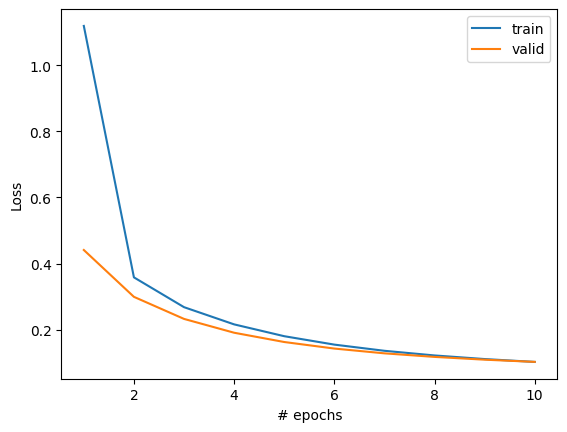

In [13]:
# Save history for later
lenet5_train_loss_history = train_loss_history
lenet5_valid_loss_history = valid_loss_history

# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, lenet5_train_loss_history, label='train')
plt.plot(x, lenet5_valid_loss_history, label='valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

We can overlay the validation curves on top of the training curves for training of LeNet5:

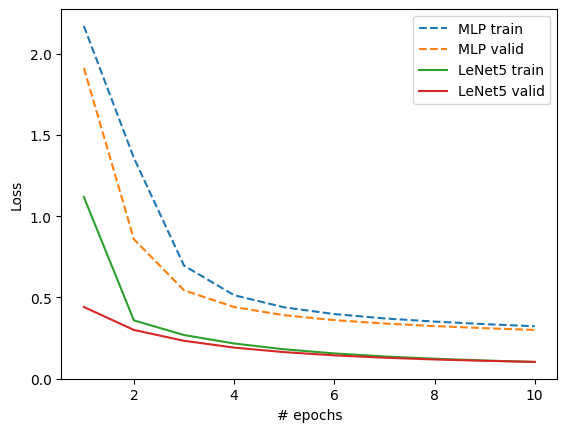

In [14]:
# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, mlp_train_loss_history, label='MLP train', linestyle='--')
plt.plot(x, mlp_valid_loss_history, label='MLP valid', linestyle='--')
plt.plot(x, lenet5_train_loss_history, label='LeNet5 train')
plt.plot(x, lenet5_valid_loss_history, label='LeNet5 valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Testing the network

#### Exercise 4

In this section, we evaluate the network's performance on test data.


In [15]:
# Set model to evaluate mode
model.eval()

correct = 0
total = 0

# Iterate over data.
for images, labels in test_loader:
    
    # put images on proper device (GPU)
    images = images.to(device)
    labels = labels.to(device)
    
    # No need to flatten the images here !

    # Forward
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
        
    # Statistics
    total += labels.size(0)
    batch_correct = torch.sum(predicted == labels.data)
    correct += batch_correct

print('Accuracy on the test set: {:.2f}%'.format(100 * correct / total))

Accuracy on the test set: 97.24%


The best results are obtained after 10 epochs!

---




### Batch normalization

#### Exercise 5

Batch normalization is a trick that often yields faster training. It acts as a regularizer by normalizing the inputs (by batch). Further, the operation is differentiable. For additional information see [article](https://arxiv.org/pdf/1502.03167v3.pdf).

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/1_Hiq-rLFGDpESpr8QNsJ1jg.png?raw=true)


Batch normalization is already implemented in the Pytorch framework so there is no need to implement it ourselves. To use it in our LeNet model, we simply treat it like any other layer : instantiate it in `__init__` and then use it in `forward`. The following class can be used:
* <a href="http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm2d">`nn.BatchNorm2d(num_features)`</a>: add batch normalisation to a 4-dimensional input encoded in a 3-dimensional tensor.

In [ ]:
class LeNet5_BatchNorm(nn.Module):
    def __init__(self):
        super(LeNet5_BatchNorm, self).__init__()

        ... # To complete.
                
    def forward(self, x):

        ... # To complete.
               
        return out
        
model = LeNet5_BatchNorm()
model = model.to(device)
  
print(model)

print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

In [16]:
class LeNet5_BatchNorm(nn.Module):
    def __init__(self):
        super(LeNet5_BatchNorm, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc = nn.Linear(7*7*32, 10)
                
    def forward(self, x):

        out = self.block1(x)

        out = self.block2(out)
        
        # Flatten the output of block2
        out = out.view(out.size(0), -1)
        
        out = self.fc(out)
               
        return out
        
model = LeNet5_BatchNorm()
model = model.to(device)
  
print(model)

print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

LeNet5_BatchNorm(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


# Parameters:  29034


Note that batch normalization adds parameters. Our new LeNet5 with batch normalization has 29 034 parameters (versus 28 938 for the original LeNet5 model without batch normalization).

**The rest (i.e., the cost function, the optimizer, the training loops, and the testing procedures) remain unchanged!**

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

since = time.time()

num_epochs = 10
train_loss_history = []
valid_loss_history = []

print("# Start training #")
for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    model.train()
    
    # Iterate over train data
    for images, labels in train_loader:  

        # put images on proper device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradient buffer
        optimizer.zero_grad()
        
        # Forward
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model.eval()
    
    # Iterate over valid data
    for images, labels in valid_loader:  
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
      
        # Statistics
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print('\nEpoch: {}/{}'.format(epoch + 1, num_epochs))
    print('\tTrain Loss: {:.4f}'.format(train_loss / train_n_iter))
    print('\tValid Loss: {:.4f}'.format(valid_loss / valid_n_iter))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Start training #

Epoch: 1/10
	Train Loss: 0.3374
	Valid Loss: 0.1477

Epoch: 2/10
	Train Loss: 0.1195
	Valid Loss: 0.1059

Epoch: 3/10
	Train Loss: 0.0899
	Valid Loss: 0.0882

Epoch: 4/10
	Train Loss: 0.0751
	Valid Loss: 0.0782

Epoch: 5/10
	Train Loss: 0.0656
	Valid Loss: 0.0714

Epoch: 6/10
	Train Loss: 0.0589
	Valid Loss: 0.0667

Epoch: 7/10
	Train Loss: 0.0538
	Valid Loss: 0.0627

Epoch: 8/10
	Train Loss: 0.0498
	Valid Loss: 0.0598

Epoch: 9/10
	Train Loss: 0.0464
	Valid Loss: 0.0573

Epoch: 10/10
	Train Loss: 0.0435
	Valid Loss: 0.0552


Training complete in 1m 33s


We obtain even better results after 10 epochs!

Let's have a look at the training and validation curves:

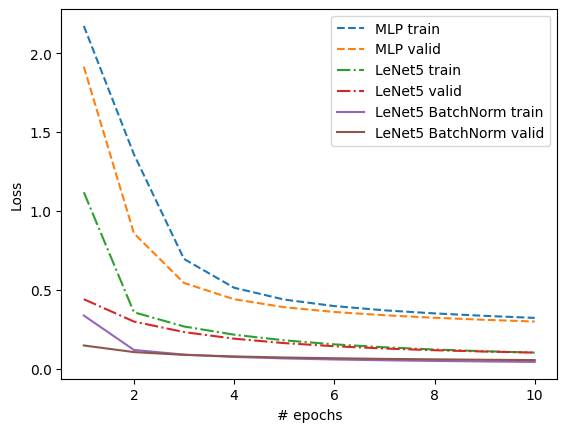

In [18]:
# Save history for later
lenet5_batchnorm_train_loss_history = train_loss_history
lenet5_batchnorm_valid_loss_history = valid_loss_history

# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, mlp_train_loss_history, label='MLP train', linestyle='--')
plt.plot(x, mlp_valid_loss_history, label='MLP valid', linestyle='--')
plt.plot(x, lenet5_train_loss_history, label='LeNet5 train', linestyle='-.')
plt.plot(x, lenet5_valid_loss_history, label='LeNet5 valid', linestyle='-.')
plt.plot(x, lenet5_batchnorm_train_loss_history, label='LeNet5 BatchNorm train')
plt.plot(x, lenet5_batchnorm_valid_loss_history, label='LeNet5 BatchNorm valid')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
# Set model to evaluate mode
model.eval()

correct = 0
total = 0

# Iterate over data.
for images, labels in test_loader:
    
    # put images on proper device (GPU)
    images = images.to(device)
    labels = labels.to(device)
    
    # No need to flatten the images here !

    # Forward
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
        
    # Statistics
    total += labels.size(0)
    batch_correct = torch.sum(predicted == labels.data)
    correct += batch_correct

print('Accuracy on the test set: {:.2f}%'.format(100 * correct / total))

Accuracy on the test set: 98.57%


# Task 2 : Object detection and instance segmentation (optional)

## Initialization

We need to be using the latest version of `pillow` for this section of the tutorial. If you are prompted with:

> WARNING: The following packages were previously imported in this runtime:
  [PIL]
You must restart the runtime in order to use newly installed versions.

Then click on restart runtime and rerun the cells afterwards.

In [20]:
!pip install --upgrade pillow==8.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import random
import numpy as np
import torch

if torch.cuda.is_available(): 
    print("Using the following accelerator type: {}".format(torch.cuda.get_device_name(0)))
else:
    print("No GPU/TPU found, try changing the runtime type if using colab.")

manualSeed = 1234
use_gpu = torch.cuda.is_available()

# Fixing random seed
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
if use_gpu:
    torch.cuda.manual_seed_all(manualSeed)

Using the following accelerator type: Tesla T4


## Object Detection Introduction
Object detection involves locating where an object is in a given image using a bounding box. The box as well as the object type are predicted by the neural network. In the case of object detection, the box is typically rectangle. While a rectangle is composed of 4 (x,y) coordinates, only 4 values are needed to reconstruct a box. For example, we could use the top right (x,y) coordinates as well as the width and height of the box. We can also use the minimum and maximum values that x and y can take: [`x_min`, `y_min`, `x_max`, `y_max`]. There can be many objects in an image, and object detectors should be able to detect all instances of various objects.

Here is an example of an image with it's associated bounding boxes.
[bbox image exmaple]

### Pretrained object detector

Before we implement our own custom object detector, let's look at how an already pre-trained object detector works. We will use a pretrained object detector from [torchvision](https://pytorch.org/vision/stable/index.html) which was trained on the [COCO](https://cocodataset.org/#home) dataset.

We will try detecting the objects in the following image:

![Image1](https://github.com/jerpint/ivado-mila-dl-school-2019-vancouver/blob/dlschool21/assests/image1.jpg?raw=true)

To do so, run the following cells:


In [22]:
'''Test our pretrained object detector on an example image'''
import os
from urllib.request import urlopen
from PIL import Image, ImageDraw, ImageFont
import numpy as np

import torchvision

# Order of COCO category names as defined in torchvision
COCO_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def display_image_and_boxes(image, target=None, category_names=None):
    ''' 
    image: tensor
    target: dict
    category_names: list mapping class label (int) to class name (str)
    
    '''

    # Convert tensor to image and draw it.
    np_img = (image.permute(1,2,0).cpu().numpy() * 255).astype('uint8')
    im = Image.fromarray(np_img)
    draw = ImageDraw.Draw(im)

    if target:
        # Make sure the required font is available
        if not os.path.isfile('Roboto-Regular.ttf'):
            !wget https://github.com/jerpint/ivado-mila-dl-school-2019-vancouver/raw/dlschool21/assests/Roboto-Regular.ttf
        font = ImageFont.truetype(font='Roboto-Regular.ttf', size=16)

        # Draw each bounding box in the target
        for box, label in zip(target['boxes'], target['labels']):
            box = box.detach().cpu().numpy()
            draw.rectangle(box, outline='black')
            label_str =  category_names[label.cpu().numpy()] if category_names else str(label.cpu().numpy()+2)
            draw.text((box[0], box[1]), label_str, fill=(0,128,256,256), font=font)
    return im


def display_masks(image, predictions, category_names=None):
    ''' 
    image: tensor
    predictions: dict
    category_names: list mapping class label (int) to class name (str)
    
    '''
    font = ImageFont.truetype(font='Roboto-Regular.ttf', size=16)
    mask_arr = np.zeros((256, 300))
    im = Image.fromarray(mask_arr)
    draw = ImageDraw.Draw(im)
    for box, label, mask in zip(predictions['boxes'], predictions['labels'], predictions['masks']):
        mask = mask.detach().cpu().numpy().squeeze()
        mask_arr += mask
        box = box.detach().cpu().numpy()
        draw.rectangle(box, outline='black')
        label_str =  category_names[label.cpu().numpy()] if category_names else str(label.cpu().numpy()+2)
        draw.text(((box[0] + box[2])/2, (box[1]+box[3])/2), label_str, fill=1, font=font)
    mask_arr = (mask_arr > 0.5) * 255
    im_with_mask = Image.fromarray( (np.array(im) + mask_arr).astype('uint8') )
    return im_with_mask


def URL_to_tensor(URL):
    '''
    Convert an image URL to a pytorch tensor.

    Reorders the image axes so that channel is the first dimension and normalizes 
    channels to be in range [0,1].

    input
    -----
    URL (str): URL of the image to be processed

    returns
    -------
    img_tensor (list): list containing the image as a torch.tensor()
    '''
    
    img = Image.open(urlopen(URL)) # Load image
    img_tensor = torch.as_tensor(np.array(img) / 255) # Normalize input to [0, 1]
    img_tensor = img_tensor.permute(2, 0, 1).float() # Reorder image axes to channel first
    return [img_tensor]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 217MB/s]


--2023-05-18 20:39:16--  https://github.com/jerpint/ivado-mila-dl-school-2019-vancouver/raw/dlschool21/assests/Roboto-Regular.ttf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jerpint/ivado-mila-dl-school-2019-vancouver/dlschool21/assests/Roboto-Regular.ttf [following]
--2023-05-18 20:39:16--  https://raw.githubusercontent.com/jerpint/ivado-mila-dl-school-2019-vancouver/dlschool21/assests/Roboto-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171272 (167K) [application/octet-stream]
Saving to: ‘Roboto-Regular.ttf’

Roboto-Regular.ttf  100%[===================>] 167.26K  --.-KB/s   

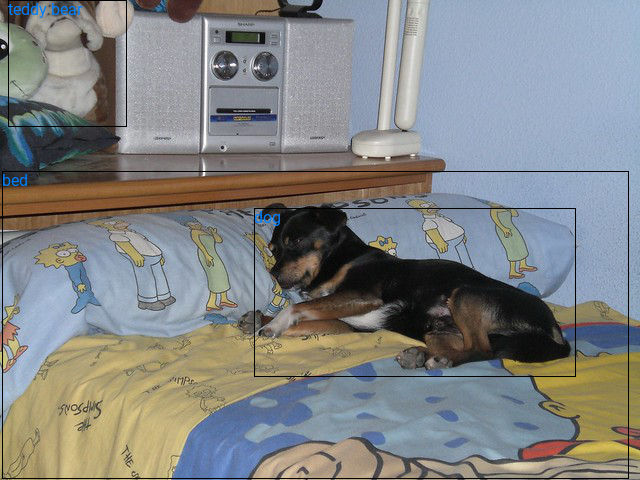

In [23]:
# Download sample image and convert to tensor
URL = 'http://farm3.staticflickr.com/2462/3889476537_9e1a7c6af4_z.jpg'
img_tensors = URL_to_tensor(URL)

# Obtain model prediction
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True,
    box_score_thresh=0.7
)
model.eval()
predictions = model(img_tensors) 

# Display image along with model prediction
display_image_and_boxes(img_tensors[0], predictions[0], category_names=COCO_CATEGORY_NAMES)


The architecture used in this case is Faster R-CNN with a ResNet-50 backbone. It is considered a two-stage object detector since there are 2 components to the network: a region-proposal network and a network which predicts bounding-boxes and object categories:

![fasterrcnn](https://github.com/jerpint/ivado-mila-dl-school-2019-vancouver/blob/dlschool21/assests/fasterrcnn.png?raw=true)

## Object Detection of Polygons

We will now explore using a new dataset to train a custom object detector. We will be constructing a synthetic polygons dataset. Our dataset will generate images with regular polygons of various colours scattered accross an image. Our object detector will have to find the polygons using bounding boxes as well as determine how many sides each polygon has.

For example, let's consider an image scattered with regular polygons of different shapes & sizes:

![polygons_nolabs](https://github.com/jerpint/ivado-mila-dl-school-2019-vancouver/raw/dlschool21/assests/polygons_nolabel.png)

Our object detector will need to find and differentiate all different instances of polygons. Note that the polygons can be overlapping, rotated, of different colors, etc. The output of our detector will look like this:

![polygon_labels](https://github.com/jerpint/ivado-mila-dl-school-2019-vancouver/raw/dlschool21/assests/polygons_labels.png)

### Polygons Dataset

#### Exercise 6

We will start by defining our own custom `Polygons` dataset, which we will define as a `torch.dataset`.

You will be responsible to complete the following methods:

`self.mask_to_bbox` and `self.img_to_tensor`

In [25]:
import random
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from PIL import Image, ImageDraw, ImageFont

class Polygons(Dataset):
  
    def __init__(self, 
                 im_width, 
                 im_height, 
                 dataset_len=100, 
                 max_polygon_size=6,
                 max_polygons_per_image=8,
                 split='train',
                 background=False):
        self.width = im_width
        self.height = im_height
        self.max_polygon_side=max_polygon_size
        self.dataset_len = dataset_len
        self.max_polygons_per_image = max_polygons_per_image
        self.split = split
        self.background = background
        self.set_offset()

    def set_offset(self):
        '''The offset determines where the random seed index begins. 

        this ensures reproducibility accross runs.
        '''
        if self.split == 'train':
            self.offset = 0
        elif self.split == 'val':
            self.offset = dataset_len
        elif self.split == 'test':
            self.offset = 2 * dataset_len
        else:
            raise ValueError("split has to be one of 'train', 'test', 'val'")

    def draw_polygon(self):
        '''
        Draws a single polygon.
        
        returns:
        bbox: coordinates of the bounding box [xmin, ymin, xmax, ymax]
        mask: Mask of the polygon, non-zero values where there is a polygon
        label: the number of sides associated to the polygon
        '''
        img = Image.new('L', (self.width, self.height), 0)
        n_sides = random.randint(3, self.max_polygon_side)
        circle_x = random.randint(10, self.width-10)
        circle_y = random.randint(10, self.height-10)
        circle_r = random.randint(10, 60)
        bounding_circle = (circle_x, circle_y, circle_r)
        rotation = random.randint(0, 360)
        ImageDraw.Draw(img).regular_polygon(bounding_circle=bounding_circle, n_sides=n_sides, rotation=rotation, fill=1, outline=None)
        mask = np.array(img) 
        bbox = self.mask_to_bbox(mask)
        label = n_sides - 2 # labels should be in range (1 ... N)
        return bbox, mask, label

    def add_random_background(self, img, seed=None):
        '''
        Add a random background to an existing image using gadients. 
        Adapted from: https://python-catalin.blogspot.com/2013/10/how-to-make-color-gradient-and-images.html

        img: Original image with white background
        img_with_bg: New image with a random background added to it
        '''

        if seed:
            random.seed(seed)
        bg = Image.new("RGB", (self.width, self.height), "#FFFFFF")
        draw = ImageDraw.Draw(bg)

        # create the background
        r,g,b = random.randint(0,255), random.randint(0,255), random.randint(0,255)
        dr = (random.randint(0, 255) - r) / self.width
        dg = (random.randint(0, 255) - g) / self.width
        db = (random.randint(0, 255) - b) / self.width
        for i in range(self.width):
            r, g, b = r + dr, g + dg, b + db
            draw.line((i, 0 , i, self.width), fill=(int(r), int(g), int(b)))
          
        # Add it to the original image
        bg_array, img_array = np.array(bg), np.array(img)
        bg_mask = np.zeros(bg_array.shape)
        bg_mask[np.where(img_array == 255)] = 1
        img_with_bg = Image.fromarray((img_array + bg_mask * bg_array).astype('uint8'))
        
        return img_with_bg
    
    def array_to_img(self, array):
        '''Convert the numpy array data to an PIL image object.
        i.e. 3 color channels [0, 255]
        

        inputs:
        array: np.array

        returns:
        PIL.Image
        '''
        cm = plt.get_cmap('cubehelix') # Use a colormap for mapping int to colour
        colored_image = cm(1 - array / 255)
        return Image.fromarray((colored_image[:, :, :3] * 255).astype(np.uint8))

    def img_to_tensor(self, img):
        '''
        convert a pil image to torch tensor.
        Must scale values to be in range 0-1. Must return a float() tensor
        reorder axes so that channel is first dimension.

        img: PIL.Image

        return: torch.tensor()
        '''
        
        # Convert the PIL Image to a Torch Tensor. Make sure to properly
        # implement all requirements stated in the docstring to avoid issues
        # with model training later on.
        img_tensor = torch.as_tensor(np.array(img) / 255)
        img_tensor = img_tensor.permute(2, 0, 1) # set the channel dimension first
        img_tensor = img_tensor.float()

        return img_tensor

    def mask_to_bbox(self, mask):
        '''
        Converts the polygon mask to bounding box coordinates.

        mask: np.array

        returns
        bbox (tuple): (xmin, ymin, xmax, ymax)
        '''

        xmin = np.min(np.nonzero(mask)[1])
        xmax = np.max(np.nonzero(mask)[1])
        ymin = np.min(np.nonzero(mask)[0])
        ymax = np.max(np.nonzero(mask)[0])
        return (xmin, ymin, xmax, ymax)
    
    def __getitem__(self, idx):
        seed = idx + self.offset
        random.seed(seed) # For reproducible datasets
        n_polygons = random.randint(1, self.max_polygons_per_image) # At least one polygon per image
        img_array = np.zeros((self.height, self.width))
        masks = []
        labels = []
        boxes = []
        areas = []
        for _ in range(n_polygons):
            bbox, mask, label = self.draw_polygon()
            boxes.append(bbox)
            masks.append(mask > 0) # Binary mask
            areas.append((bbox[2]-bbox[0]) * (bbox[3]-bbox[1]))
            labels.append(label)
            img_array += mask / np.max(mask) * random.randint(0, 254) # random color

        # Convert array to RGB image
        img = self.array_to_img(img_array)

        # Add background if specified
        if self.background:
            img = self.add_random_background(img, seed)

        # Convert img to tensor
        img_tensor = self.img_to_tensor(img) 

        # Define targets appropriately as tensors
        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)
        target["image_id"] = torch.tensor([idx])
        target["area"] = torch.as_tensor(areas, dtype=torch.int64)
        target["iscrowd"] = torch.as_tensor([0] * len(labels), dtype=torch.int64)

        return img_tensor, target

    def __len__(self):
        return self.dataset_len 
      

Lets start by exploring what the dataset does. For each index, it generates a new image with a random assortment of polygons and their associated labels.

The labels are binary masks that represent each polygon as well as class labels that represent the number of sides of each polygon. Since pytorch indexes classes at 0, and we require a background class, the class associated to a polygon is  `class+2` when `class` > 1, and `background` otherwise.

If you have properly implemented `self.img_to_tensor`, running the cell below will correctly display a sample from the Polygon dataset. You should see polygons of various colors over a white background.

<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)
<ipython-input-25-0e9f68d6444d>:175: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)


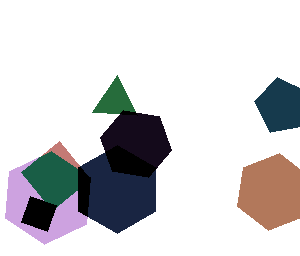

In [26]:
polygon_dataset = Polygons(im_width=300, im_height=256)
img, target = polygon_dataset[490]

im = display_image_and_boxes(img)
display(im)

If you have properly implemented `self.mask_to_bbox`, running the cell below will correctly display the same sample example as before but with tight bounding boxes around each of the polygons in the image.

<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)


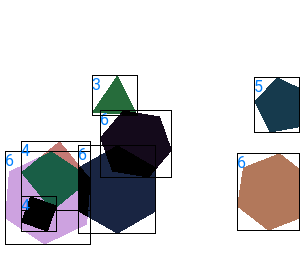

In [27]:
polygon_dataset = Polygons(im_width=300, im_height=256)
img, target = polygon_dataset[490]

im = display_image_and_boxes(img, target)
display(im)

Finally, the cell below demonstrates another feature of the Polygons class. By specifying `background=True`, the Polygons class will generate example with non-white backgrounds in order to make the detection task more difficult.

<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)


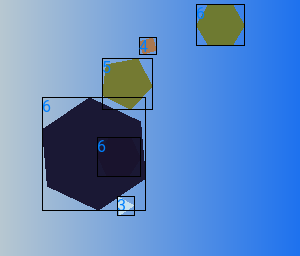

In [28]:
polygon_ds_with_bg = Polygons(im_width=300, im_height=256, background=True)
img, target = polygon_ds_with_bg[4921]

im = display_image_and_boxes(img, target)
display(im)

### Fetching utility files

We will be using some handy utility functions directly from torchvision's repo. Running the cell below will fetch them and store them in your working directory. It will also open a window so you can look at what some of the functions do. Most of it is to run training loops and to evaluate performances. No need to reinvent the wheel!

In [29]:
# Fetch some useful util files provided by torchvision
# Open them in a side view
from google.colab import files
fnames = ['engine.py', 'utils.py', 'coco_utils.py', 'coco_eval.py', 'transforms.py']
for f in fnames:
    URL = "https://raw.githubusercontent.com/pytorch/vision/master/references/detection/" + f
    !wget -O {f} {URL}
    files.view(f)

--2023-05-18 20:45:11--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4032 (3.9K) [text/plain]
Saving to: ‘engine.py’

engine.py           100%[===================>]   3.94K  --.-KB/s    in 0s      

2023-05-18 20:45:11 (47.8 MB/s) - ‘engine.py’ saved [4032/4032]



<IPython.core.display.Javascript object>

--2023-05-18 20:45:11--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   8.19K  --.-KB/s    in 0s      

2023-05-18 20:45:11 (91.5 MB/s) - ‘utils.py’ saved [8388/8388]



<IPython.core.display.Javascript object>

--2023-05-18 20:45:11--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8893 (8.7K) [text/plain]
Saving to: ‘coco_utils.py’

coco_utils.py       100%[===================>]   8.68K  --.-KB/s    in 0s      

2023-05-18 20:45:12 (76.0 MB/s) - ‘coco_utils.py’ saved [8893/8893]



<IPython.core.display.Javascript object>

--2023-05-18 20:45:12--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6447 (6.3K) [text/plain]
Saving to: ‘coco_eval.py’

coco_eval.py        100%[===================>]   6.30K  --.-KB/s    in 0s      

2023-05-18 20:45:12 (77.0 MB/s) - ‘coco_eval.py’ saved [6447/6447]



<IPython.core.display.Javascript object>

--2023-05-18 20:45:12--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23337 (23K) [text/plain]
Saving to: ‘transforms.py’

transforms.py       100%[===================>]  22.79K  --.-KB/s    in 0.001s  

2023-05-18 20:45:12 (30.1 MB/s) - ‘transforms.py’ saved [23337/23337]



<IPython.core.display.Javascript object>

### Defining the model

#### Exercise 7

We will now need to define the model that we will be using to train our object detector. It will be a slight variant from Faster R-CNN with the main difference being the number of possible classes that the network can output.

Since the overall architecture of Faster R-CNN can be rather complex, we will simply replace the layer responsible for bounding box regression and classification to be adapted to our task.

We could directly call the `fasterrcnn_resnet50_fpn` model with the appropriate number of classes, however, this would not allow us to use a pretrained model.

Instead, we can use the `FastRCNNPredictor` class and replace the `box_predictor` portion of the network. Looking at the [documentation](https://pytorch.org/vision/stable/_modules/torchvision/models/detection/faster_rcnn.html#fasterrcnn_resnet50_fpn), `FastRCNNPredictor` expects the number of input channels as well as the number of output channels. In our case, the number of output channels will be the number of classes we have to predict (including the background). The number of input channels will remain the same.

In [30]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_object_detection(num_classes, pretrained=True, box_score_thresh=0.5):
    ## Load the pretrained fasterrcnn_resnet50_fpn model and specify box_score_thresh as a kwarg
    model = fasterrcnn_resnet50_fpn(pretrained=pretrained, box_score_thresh=box_score_thresh)
    
    ## Determine number of input features for new FastRCNNPredictor
    predictor_in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the model's classifier with a new instance of FastRCNNPredictor,
    # that has the number of classes changed to what we are doing in this task
    model.roi_heads.box_predictor = FastRCNNPredictor(predictor_in_features, num_classes)
    
    return model

Now that we have defined our model, let's see what kind of predictions our model is making prior to re-training our model. To do so, we will define a data loader, set the model to `eval` and do a forward pass on a single example image:

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)
<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)
<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be in

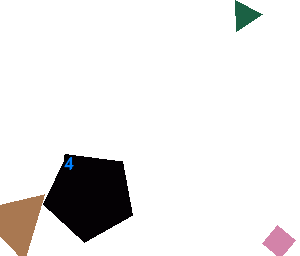

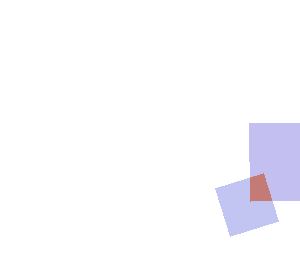

In [31]:
import utils
# Do a prediction on the model prior to fine tuning
polygon_ds = Polygons(im_width=300, im_height=256)
data_loader = torch.utils.data.DataLoader(
 polygon_ds, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)

num_classes = polygon_ds.max_polygon_side - 2
model = get_model_object_detection(num_classes)

model.eval()

# Show a batch worth of images and their predictions
images, _ = next(iter(data_loader))
predictions = model(images)           # Returns predictions
for n in range(len(predictions)):
    display(display_image_and_boxes(images[n], predictions[n]))

### Training Loop

#### Exercise 8

You will now implement the training loop for our object detector. We will use the `train_one_epoch` utility provided by torchvision.

First, you will have to define a train and validation dataset, and construct appropriate dataloaders for them. Do not forget to use the dataset's `split` argument. Also do not forget to use the `colate_fn` provided in `utils.py` as the `collate_fn` argument in the `DataLoader` object.

Use a `dataset_len` of 100 for each dataset. It can be useful to shuffle the train dataset. Use `im_width` = 300 and `im_height` = 256.

For the optimizer, we will use `SGD` with an initial learning rate of 0.005. Set the momentum to be 0.9 and the weight_decay to be 0.0005 (as in the original faster RCNN implementation).

We will also use a scheduler to decrease the learning rate on every step. For this, we will use the `torch.optim.lr_scheduler.StepLR` utility. Set the step_size to be 3 and the gamma to 0.1. This will decrease the learning rate for us automatically throughout our training.

We will train for 5 epochs total.

In [32]:
from engine import train_one_epoch, evaluate
import utils

dataset_len = 100
im_width = 300
im_height = 256
batch_size=2

# Instantiate training dataset and training dataloader
dataset_train = Polygons(im_width, im_height, dataset_len=dataset_len, split='train')
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=utils.collate_fn)

# Instantiate validation dataset and validation dataloader
dataset_val = Polygons(im_width, im_height, dataset_len=dataset_len, split='val')
data_loader_val = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False, collate_fn=utils.collate_fn)


# Instantiate test dataset and test dataloader
dataset_test = Polygons(im_width, im_height, dataset_len=dataset_len, split='test')
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)


# get the model using our helper function (get_model_object_detection)
num_classes = dataset_train.max_polygon_side - 1
model = get_model_object_detection(num_classes)

# Set trainable parameters
params = [p for p in model.parameters() if p.requires_grad]

# construct an optimizer
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# construct a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# set the number of epochs
num_epochs = 5


# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model to the right device
model.to(device)
print(f"Using {device} as accelerator harward")

# train model for specified number of epochs
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the validation dataset
    evaluate(model, data_loader_val, device=device)

print("End of training.")

Using cuda as accelerator harward


<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)


Epoch: [0]  [ 0/50]  eta: 0:00:48  lr: 0.000107  loss: 2.4507 (2.4507)  loss_classifier: 1.8964 (1.8964)  loss_box_reg: 0.4959 (0.4959)  loss_objectness: 0.0540 (0.0540)  loss_rpn_box_reg: 0.0044 (0.0044)  time: 0.9678  data: 0.4277  max mem: 1930
Epoch: [0]  [10/50]  eta: 0:00:40  lr: 0.001126  loss: 2.0039 (2.0150)  loss_classifier: 1.0524 (1.1707)  loss_box_reg: 0.7134 (0.7704)  loss_objectness: 0.0651 (0.0677)  loss_rpn_box_reg: 0.0045 (0.0062)  time: 1.0076  data: 0.5887  max mem: 2089
Epoch: [0]  [20/50]  eta: 0:00:27  lr: 0.002146  loss: 1.3142 (1.5475)  loss_classifier: 0.5532 (0.8134)  loss_box_reg: 0.6732 (0.6869)  loss_objectness: 0.0149 (0.0421)  loss_rpn_box_reg: 0.0036 (0.0050)  time: 0.9054  data: 0.4990  max mem: 2089
Epoch: [0]  [30/50]  eta: 0:00:17  lr: 0.003165  loss: 1.0310 (1.3923)  loss_classifier: 0.3967 (0.6818)  loss_box_reg: 0.5981 (0.6715)  loss_objectness: 0.0137 (0.0331)  loss_rpn_box_reg: 0.0040 (0.0059)  time: 0.8106  data: 0.4041  max mem: 2089
Epoch: [

### Model evaluation

Now set your model to `eval` and define a test dataset and dataloader to evaluate the model on the test set.

How is your model performing overall? Does it seem to generalize well from the training set? Does it perform better, worse, same, on different sized objects?

It can be helpful to visually inspect how your network is performing by plotting some of the object detection results.

<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)


creating index...
index created!
Test:  [ 0/50]  eta: 0:01:35  model_time: 0.2766 (0.2766)  evaluator_time: 0.0132 (0.0132)  time: 1.9107  data: 1.6193  max mem: 2089
Test:  [49/50]  eta: 0:00:00  model_time: 0.1942 (0.1994)  evaluator_time: 0.0086 (0.0115)  time: 0.3894  data: 0.1796  max mem: 2089
Test: Total time: 0:00:24 (0.4833 s / it)
Averaged stats: model_time: 0.1942 (0.1994)  evaluator_time: 0.0086 (0.0115)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.764
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.865
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.840
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.763
 Average Recall     (AR) @[ IoU=

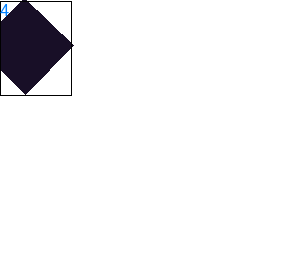

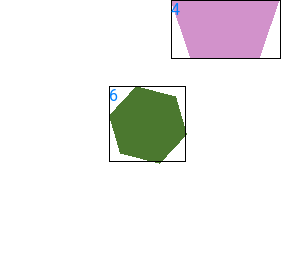

In [33]:
model.eval()
evaluate(model, data_loader_test, device=device)

# Look at predictions from a batch
test_iter = iter(data_loader_test)
images, targets = next(test_iter)
images = [image.to(device) for image in images]
predictions = model(images)
for idx in range(len(images)):
    display(display_image_and_boxes(images[idx], predictions[idx]))

### Generalization

We will now see how our model generalizes to "unusual" cases. So far, our model has only seen shapes on white backgrounds.

Lets add a random gradient-based background to the test dataset and see how well our model does. This can be done by setting the `background=True` argument in the dataset class.


<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)


creating index...
index created!
Test:  [ 0/50]  eta: 0:01:55  model_time: 0.3253 (0.3253)  evaluator_time: 0.0129 (0.0129)  time: 2.3180  data: 1.9783  max mem: 2089
Test:  [49/50]  eta: 0:00:00  model_time: 0.1837 (0.2094)  evaluator_time: 0.0057 (0.0116)  time: 0.3820  data: 0.1843  max mem: 2089
Test: Total time: 0:00:26 (0.5366 s / it)
Averaged stats: model_time: 0.1837 (0.2094)  evaluator_time: 0.0057 (0.0116)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.613
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.722
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.621
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.498
 Average Recall     (AR) @[ IoU=

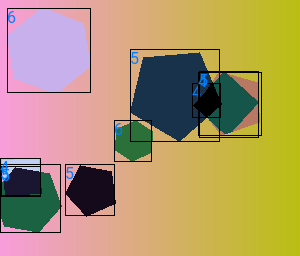

In [34]:
# Use a test set with a random background this time
dataset_len = 100
polygon_ds_with_bg = Polygons(im_width=300, 
                              im_height=256, 
                              dataset_len=dataset_len, 
                              background=True, 
                              split='test')


data_loader_test_bg = torch.utils.data.DataLoader(
    polygon_ds_with_bg, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

# Evaluate on entire test set
evaluate(model, data_loader_test_bg, device=device)

# Evaluate single sample
bg_iter = iter(data_loader_test_bg)
images, targets = next(bg_iter)

model.eval()
images = [image.to(device) for image in images]
predictions = model(images)           # Returns predictions

display_image_and_boxes(images[0], predictions[0])

Analysis of the results : 
- How does the model react to having background on a single example?
- How does the overall performance get affected on the entire test set?
- How could performance be improved on the test set?

Bonus exercises :
- Test the model on a test set in which example contain more polygons than the data used to train the model. Does the model generalize well to a higher number of polygons? How high can you increase the number of polygons before the performance of the model is severely affected?
- Finetune the model on data with non-white background instead. How does performance vary on the test set?

## Instance Segmentation

We will now use the binary masks to do instance segmentation instead of object detection. In instance segmentation, the goal is to not only detect an object, but also to determine which pixels correspond to that very object. Since we are defining our polygons using binary masks, we will be able to use those as our ground truth training data.

The architecture we will use is Mask-RCNN. It is similar to Faster-RCNN but has an additional branch for segmentation. The architecture sketch is shown here:

![maskrcnn](https://github.com/jerpint/ivado-mila-dl-school-2019-vancouver/blob/dlschool21/assests/maskrcnn.png?raw=true)

### Model declaration

We will begin by defining our model. Just like with Faster RCNN, we will use a pre-trained model and replace the appropriate parts of the network. We will have to replace both the object detector portion of the network as well as the mask prediction portion of the network to be adapted to our task.

In this case, there are 2 parts of the network we will be replacing - `FasterRCNNPredictor`, just like in the previous example, which will do bounding box regression, as well as the `MaskRCNNPredictor` which will be used for segmentation.

In [35]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes, pretrained=True, box_score_thresh=0.7):

    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=pretrained, box_score_thresh=box_score_thresh
      )

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained box detector with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


In [36]:
# Define our datasets with the different splits
dataset_len = 100
batch_size = 2


# Instantiate training dataset and training dataloader
dataset_train = Polygons(im_width, im_height, dataset_len=dataset_len, split='train', background=True)
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=utils.collate_fn)

# Instantiate validation dataset and validation dataloader
dataset_val = Polygons(im_width, im_height, dataset_len=dataset_len, split='val', background=True)
data_loader_val = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False, collate_fn=utils.collate_fn)


# Instantiate test dataset and test dataloader
dataset_test = Polygons(im_width, im_height, dataset_len=dataset_len, split='test', background=True)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)


Let's look at some of the predicted masks of the network before training:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:04<00:00, 37.0MB/s]
<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)
<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["mas

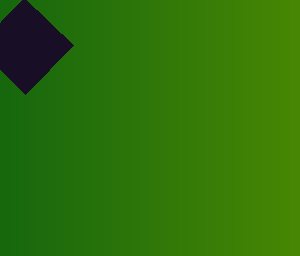

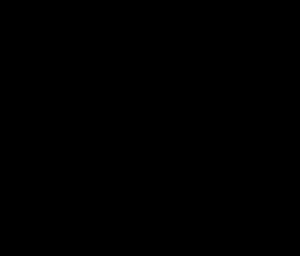

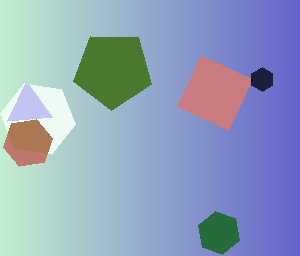

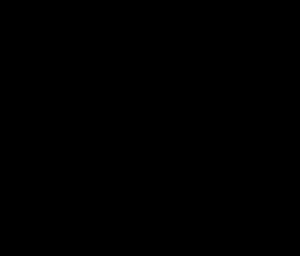

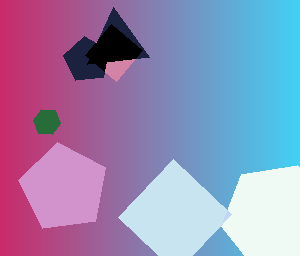

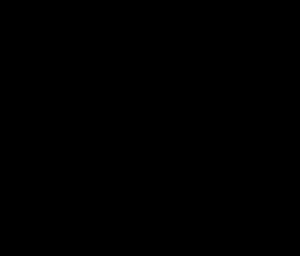

In [37]:
# get the model using our helper function
num_classes = dataset_train.max_polygon_side - 1

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(num_classes, box_score_thresh=0.5)
model.to(device);

# Look at predictions on the test set before fine-tuning
dl_iter = iter(data_loader_test)

for i in range(3):
    images, _ = next(dl_iter)
    
    model.eval()
    images = [image.to(device) for image in images]
    predictions = model(images)           # Returns predictions
    display(display_image_and_boxes(images[0], predictions[0]))
    display(display_masks(images[0], predictions[0]))

### Training Loop

#### Exercise 9

Construct an optimizer and a learning rate scheduler. 
Use SGD with `lr=0.005`, `momentum=0.9` and `weight_decay=0.0005` for the optimizer.
Use `step_size=3` and `gamma=0.1` for the learning rate scheduler (hint: use StepLR)

In [39]:
# Train the model

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it for 5 epochs
num_epochs = 5
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)


Epoch: [0]  [ 0/50]  eta: 0:01:07  lr: 0.000107  loss: 5.2773 (5.2773)  loss_classifier: 1.5095 (1.5095)  loss_box_reg: 0.9764 (0.9764)  loss_mask: 2.7162 (2.7162)  loss_objectness: 0.0689 (0.0689)  loss_rpn_box_reg: 0.0063 (0.0063)  time: 1.3550  data: 0.7328  max mem: 3073
Epoch: [0]  [10/50]  eta: 0:00:44  lr: 0.001126  loss: 3.1846 (3.3363)  loss_classifier: 0.8615 (0.9931)  loss_box_reg: 0.9028 (0.7853)  loss_mask: 1.3517 (1.4516)  loss_objectness: 0.1062 (0.0951)  loss_rpn_box_reg: 0.0109 (0.0112)  time: 1.1026  data: 0.5848  max mem: 3288
Epoch: [0]  [20/50]  eta: 0:00:30  lr: 0.002146  loss: 2.0815 (2.5219)  loss_classifier: 0.6394 (0.7569)  loss_box_reg: 0.7383 (0.7102)  loss_mask: 0.5339 (0.9810)  loss_objectness: 0.0378 (0.0633)  loss_rpn_box_reg: 0.0090 (0.0105)  time: 0.9867  data: 0.4843  max mem: 3288
Epoch: [0]  [30/50]  eta: 0:00:19  lr: 0.003165  loss: 1.2752 (2.0848)  loss_classifier: 0.3581 (0.6244)  loss_box_reg: 0.5253 (0.6543)  loss_mask: 0.3628 (0.7510)  loss_ob

### Model Evaluation

Now that the training is done, lets look at the quality of our predictions - we will plot bounding boxes overlayed on top of the original images as well as segmentation masks.

<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)
<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)
<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)
<ipython-input-25-0e9f68d6444d>:175: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)


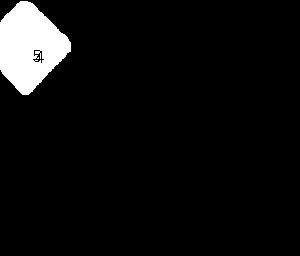

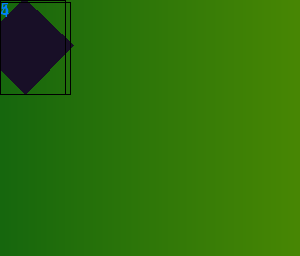

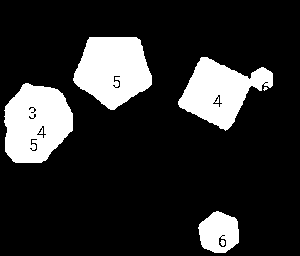

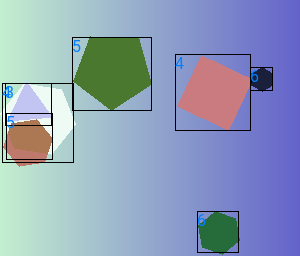

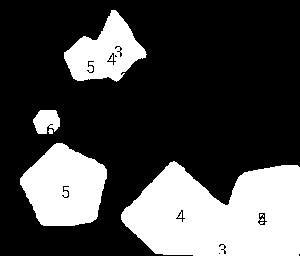

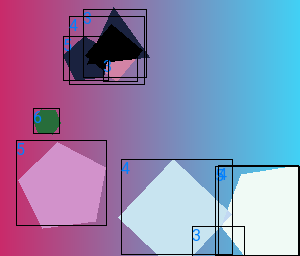

In [40]:
dl_iter = iter(data_loader_test)

for n in range(3):
    images, _ = next(dl_iter)
  
    model.eval()
    images = [image.to(device) for image in images]
    predictions = model(images)           # Returns predictions
    display(display_masks(images[0], predictions[0]))
    display(display_image_and_boxes(images[0], predictions[0]))

# References
Various parts of this tutorial are inspired from these other tutorials: 
* https://github.com/andrewliao11/dni.pytorch/blob/master/mlp.py
* https://github.com/andrewliao11/dni.pytorch/blob/master/cnn.py
* http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
* http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* http://cs231n.github.io/convolutional-networks/
* http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html#convolution-as-a-matrix-operation
